# Customize DNN: Models and Training Algorithms
## 1. Custom Loss Function
Important note: Save and Load model, saving model is in a normal way, but loading model requires the custom objects that used to map the function name to the actual function.
```
model = keras.models.load_model("my_model_with_a_custom_loss.h5", custom_objects={"huber_fn": huber_fn})
```

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats
import os

%matplotlib inline

In [2]:
# load California housing dataset
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target.reshape(-1, 1), test_size=0.1, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=42)

# scaling input data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [3]:
X_train_scaled.shape, X_valid_scaled.shape, X_test_scaled.shape

((13003, 8), (5573, 8), (2064, 8))

In [4]:
# defines Huber Loss function
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss =tf.square(error) / 2
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

2022-04-13 11:57:53.410304: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-13 11:57:53.701255: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1486 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


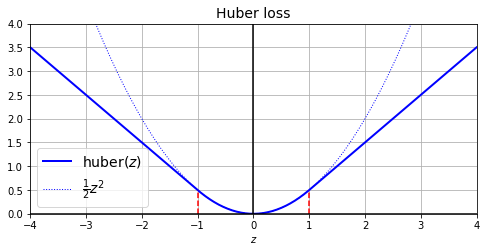

In [5]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [6]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [7]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
134/407 [========>.....................] - ETA: 0s - loss: 0.9918 - mae: 1.4262

2022-04-13 11:57:54.911229: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


407/407 [==============================] - 2s 2ms/step - loss: 0.5252 - mae: 0.8756 - val_loss: 0.2335 - val_mae: 0.5252
Epoch 2/2
407/407 [==============================] - 1s 1ms/step - loss: 0.2187 - mae: 0.5095 - val_loss: 0.2103 - val_mae: 0.4921


In [8]:
# save and load model with custom objects
model.save("models/my_model_with_a_custom_loss.h5")

In [9]:
model = keras.models.load_model("models/my_model_with_a_custom_loss.h5",
                                custom_objects={"huber_fn": huber_fn})

# training model again
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
407/407 [==============================] - 1s 2ms/step - loss: 0.2073 - mae: 0.4940 - val_loss: 0.2033 - val_mae: 0.4848
Epoch 2/2
407/407 [==============================] - 1s 1ms/step - loss: 0.2020 - mae: 0.4870 - val_loss: 0.2042 - val_mae: 0.4926


In [10]:
# configuration different threshold for custom loss function
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss = threshold * tf.abs(error) - threshold**2/2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

model.compile(loss=create_huber(2.0), optimizer='nadam', metrics=['mae'])

In [11]:
model.fit(X_train_scaled, y_train, validation_data=(X_valid_scaled, y_valid), epochs=2)

Epoch 1/2
407/407 [==============================] - 1s 2ms/step - loss: 0.2311 - mae: 0.4883 - val_loss: 0.2354 - val_mae: 0.4901
Epoch 2/2
407/407 [==============================] - 1s 1ms/step - loss: 0.2261 - mae: 0.4847 - val_loss: 0.2271 - val_mae: 0.4764


In [12]:
model.evaluate(X_test_scaled, y_test)

65/65 [==============================] - 0s 671us/step - loss: 0.2248 - mae: 0.4859


[0.22484855353832245, 0.48593869805336]

In [13]:
# model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5", custom_objects={"huber_fn": create_huber(2.0)})

In [14]:
# You can solve this by creating a subclass of the keras.losses.Loss class, and then implementing its get_config() method:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}


model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

In [15]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
407/407 [==============================] - 1s 2ms/step - loss: 0.7096 - mae: 0.8807 - val_loss: 0.2766 - val_mae: 0.5331
Epoch 2/2
407/407 [==============================] - 1s 1ms/step - loss: 0.2567 - mae: 0.5210 - val_loss: 0.2545 - val_mae: 0.5079


In [16]:
# model.save("my_model_with_a_custom_loss_class.h5")
# model = keras.models.load_model("my_model_with_a_custom_loss_class.h5", custom_objects={"HuberLoss": HuberLoss})

The constructor passes \**kwargs to the parent constructor by super().\__init__(\**kwargs). 

The call() method takes the labels and predictions, computes all the instance losses, and return them

The get_config() method return a dictionary mapping each hyperparameter name to its values.

# Other custom Functions: custom Activation functions, Initializers, Regularizers, and Constraints
Most Keras functionalities, such as losses, regularizers, constraints, initializers, metrics, activation functions, layers, and even full models, can be customized in very much the same way. Most of the time, you will just need to write a simple function with the appropriate inputs and outputs.

In [17]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# customize 
def my_softplus(z): # return value is just tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [18]:
## using customized functions
# layer = keras.layers.Dense(1, activation=my_softplus,
#                           kernel_initializer=my_glorot_initializer,
#                           kernel_regularizer=my_l1_regularizer,
#                           kernel_constraint=my_positive_weights)              

In [19]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [20]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
407/407 [==============================] - 1s 2ms/step - loss: 1.5735 - mae: 0.8734 - val_loss: 0.6552 - val_mae: 0.5444
Epoch 2/2
407/407 [==============================] - 1s 1ms/step - loss: 0.6401 - mae: 0.5259 - val_loss: 0.5321 - val_mae: 0.4991


In [21]:
## save and load model with all customized functions

#model.save("my_model_with_many_custom_parts.h5")

# model = keras.models.load_model("my_model_with_many_custom_parts.h5",
#    custom_objects={
#       "my_l1_regularizer": my_l1_regularizer,
#       "my_positive_weights": my_positive_weights,
#       "my_glorot_initializer": my_glorot_initializer,
#       "my_softplus": my_softplus,
#    })

In [22]:
## given hyperparameter to function and saving it with model by defining a subclass the approriate class, such as keras.regularizers.Regularizer, 
## keras.constraints.Constraint, keras.initializers.Initializer

class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor": self.factor}

## implement the call() method for losses, layers (including activation functions), and models
## the __call__() method for regularizers, initializers, and constraints. For metrics, things are a bit different,

In [23]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [24]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
407/407 [==============================] - 1s 2ms/step - loss: 1.5735 - mae: 0.8734 - val_loss: 0.6552 - val_mae: 0.5444
Epoch 2/2
407/407 [==============================] - 1s 1ms/step - loss: 0.6401 - mae: 0.5259 - val_loss: 0.5321 - val_mae: 0.4991


In [25]:
## load model
#model = keras.models.load_model("my_model_with_many_custom_parts.h5",
#    custom_objects={
#       "MyL1Regularizer": MyL1Regularizer,
#       "my_positive_weights": my_positive_weights,
#       "my_glorot_initializer": my_glorot_initializer,
#       "my_softplus": my_softplus,
#    })

# Custom Metrics
*Losses and Metrics* are conceptually not the same thing:
- Losses (e.g., cross entropy) are used by Gradient Descent to train model, so they must differentiable (at least where they arre evaluated), and their gradient should not be 0 anywhere. It is not easy interpretable by humans.
- Metrics (e.g., accuracy) are used to evaluate a model: they must be more easily interpretable, and they can be non-differentiable or have 0 gradient everywhere.

In some cases, defining custom metrics is exactly the same as defining a custom loss function. ```model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])``` (using the create_huber class of loss function for custom metrics is fine)

**Note:** if you use the same function as the loss and a metric, you may be surprised to see different results. This is generally just due to floating point precision errors: even though the mathematical equations are equivalent, the operations are not run in the same order, which can lead to small differences. Moreover, when using sample weights, there's more than just precision errors:

- the loss since the start of the epoch is the mean of all batch losses seen so far. Each batch loss is the sum of the weighted instance losses divided by the batch size (not the sum of weights, so the batch loss is not the weighted mean of the losses).
- the metric since the start of the epoch is equal to the sum of weighted instance losses divided by sum of all weights seen so far. In other words, it is the weighted mean of all the instance losses. Not the same thing.

If you do the math, you will find that loss = metric * mean of sample weights (plus some floating point precision error).

### Streaming metric: Precision


In [26]:
precision = keras.metrics.Precision()
# first batch
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [27]:
# second batch
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [28]:
# get current value of the metric
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [29]:
# variables of precision
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [30]:
# reset all variables 
precision.reset_states()
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [31]:
# customize subclass metrics from keras.metrics.Metric
class HuberMetric(keras.metrics.Metric):
    
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    
    def result(self):
        return self.total / self.count
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

- The constructor use the add_weight() to create the variables needed to keep track of the metric's state over multiple batches. "total" is the sum of all Huber losses, and "count" is the number of instances seen so far.
- The update_state() to update all variables, gives the labels, and predictions for one batch.
- The result() computes and returns the final result, in that case, the Huber metric over all instances
- The get_config() save the threshold along with the model. If we use this class as function, the update_state() is called first, and then the result() to return a result.
- The default implementation of the reset_states() method resets all variables to 0.0, but we can override it if needed

In [32]:
# use as function
m = HuberMetric(2.)
m(tf.constant([[2.]]), tf.constant([[10.]]))

## it computes:
# total = 2 * |10 - 2| - 2²/2 = 14
# count = 1
# result = 14 / 1 = 14

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [33]:
# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [34]:
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=21.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=3.0>]

In [35]:
# check the HuberMetric work
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[HuberMetric(2.0)])

In [36]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
407/407 [==============================] - 1s 1ms/step - loss: 0.8106 - huber_metric: 0.8106
Epoch 2/2
407/407 [==============================] - 0s 1ms/step - loss: 0.2524 - huber_metric: 0.2524


In [37]:
model.save("models/my_model_with_huber_metric.h5")

In [38]:
model = keras.models.load_model("models/my_model_with_huber_metric.h5", custom_objects={"huber_fn":create_huber(2.0), "HuberMetric":HuberMetric()})

In [39]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
407/407 [==============================] - 1s 1ms/step - loss: 0.2373 - huber_metric: 0.2373
Epoch 2/2
407/407 [==============================] - 0s 1ms/step - loss: 0.2307 - huber_metric: 0.2307


In [40]:
model.metrics[-1].threshold

2.0

In [42]:
model.metrics

# Custom Layers
the simplest option is to write a function and wrap it in a ```keras.layers.Lambda layer```. For example, the following layer will apply the exponential function to its inputs:

The custom layer can be used like any other layer, using Sequential API, Functional API, or the Subclassing API, and also use it as an activation function (for Exponential layer).

Custom a subclass of ```keras.layers.Layer``` class:

In [43]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}

- The constructor takes all the hyperparameters as arguments (e.g., input units, activation), take care of standard arguments such as **input_shape, trainable, and name**. Save all hyperparameters as attributes, converting the activation argument to the approriate activation function by using the ```keras.activations.get()``` method.
- The build() method's role is to create the layer's variables by calling the add_weight() method for each weight. This method is called first when the layer is used. At this point, Keras knew the shape of previous neurons by the ```batch_input_shape``` argument to establish connections of weights metrix (i.e., kernel). At the end of this method, must call the parent's build() method to tell Keras builds this layer by setting ```self.build=True```.
- The call() method performs the desired operations. We just compute the input X and the layer's kernel, adding the bias vector, and then apply the activation function to the result, and this give us the output of the layer.
- The compute_output_shape() method simply returns the shape of this layer's outputs. The shape is the same as input's shape (by batch_input_shape argument) and can convert to Python lists by using as_list(). 
- The get_config() method to comfirm everything is done for this layer, and calling the ```keras.activations.serialize()``` to save the units, and activation arguments

You can generally omit the compute_output_shape() method, as tf.keras automatically infers the output shape, except when the layer is dynamic (as we will see shortly). In other Keras implementations, this method is either required or its default implementation assumes the output shape is the same as the input shape.

#### Multiple inputs (eg., Concatenate)
The argument the the call() method should be a tuple containing all the inputs, and similarly the argument to the compute_output_shape() method should be a tuple containing each input's batch shape.
```
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        return [X1 + X2, X1 * X2, X1 / X2]

    def compute_output_shape(self, batch_input_shape):
        b1, b2 = batch_input_shape
        return [b1, b1, b1] # should probably handle broadcasting rules
```
This layer may now be used like any other layer, but only using the Functional and Subclassing APIs, not the Sequential API (which only accepts layers with one input and one output).

If your layer needs to have a different behavior during training and during testing (e.g., if it uses Dropout or BatchNormalization layers), then you must add a train ing argument to the call() method and use this argument to decide what to do. For example, let’s create a layer that adds Gaussian noise during training (for regularization) but does nothing during testing (Keras has a layer that does the same thing, keras.layers.GaussianNoise ):
```
class MyGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X
            
    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape
```

In [44]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])

In [46]:
model.compile(loss="mse", optimizer="nadam", metrics=['accuracy'])

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

model.evaluate(X_test_scaled, y_test)

Epoch 1/2
407/407 [==============================] - 1s 2ms/step - loss: 0.5208 - accuracy: 0.0028 - val_loss: 0.4563 - val_accuracy: 0.0038
Epoch 2/2
65/65 [==============================] - 0s 637us/step - loss: 0.4535 - accuracy: 9.6899e-04


[0.4535139501094818, 0.0009689922444522381]

In [47]:
# multiple layer
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        print("X1.shape: ", X1.shape ," X2.shape: ", X2.shape) # Debugging of custom layer
        return X1 + X2, X1 * X2

    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape2]

In [48]:
# our custom layer can be called using the Functional API like this:

inputs1 = keras.layers.Input(shape=[2])
inputs2 = keras.layers.Input(shape=[2])
outputs1, outputs2 = MyMultiLayer()((inputs1, inputs2))

X1.shape:  (None, 2)  X2.shape:  (None, 2)


Define a Functional model using the multiple layer
```
input_A = keras.layers.Input(shape=X_train_scaled_A.shape[-1])
input_B = keras.layers.Input(shape=X_train_scaled_B.shape[-1])
hidden_A, hidden_B = MyMultiLayer()((input_A, input_B))
hidden_A = keras.layers.Dense(30, activation='selu')(hidden_A)
hidden_B = keras.layers.Dense(30, activation='selu')(hidden_B)
concat = keras.layers.Concatenate()((hidden_A, hidden_B))
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])
```

# Custom Models
subclass the keras.Model class, create layers and variables in the constructor, and implement the call() method to do whatever you want the model to do.

In [49]:
## create a ResidualBlock class (a layer), that composes of two dense layers, and an addition operation (add its inputs to its outputs), then do 3 loops of the ResidualBlock, 
## and goes through a second ResidualBlock. The final result goes through the dense output layer.

class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu", kernel_initializer="he_normal") for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z
    
## This layer is a bit special since it contains other layers. This is automatically handled Transparently by Keras. 

In [50]:
## next, use the Subclassing API to define the model itself.

class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [51]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

X_new_scaled = X_test_scaled

# simple using, just create and call
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
407/407 [==============================] - 1s 2ms/step - loss: 12.5406
Epoch 2/5
407/407 [==============================] - 1s 2ms/step - loss: 3.0691
Epoch 3/5
407/407 [==============================] - 1s 2ms/step - loss: 1.0037
Epoch 4/5
407/407 [==============================] - 1s 2ms/step - loss: 0.8037
Epoch 5/5
65/65 [==============================] - 0s 800us/step - loss: 0.5307


In [52]:
model.save("models/my_custom_model.ckpt")

2022-04-13 16:05:32.550557: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/my_custom_model.ckpt/assets


INFO:tensorflow:Assets written to: models/my_custom_model.ckpt/assets


In [53]:
model = keras.models.load_model("models/my_custom_model.ckpt")

In [54]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
407/407 [==============================] - 1s 2ms/step - loss: 0.6891
Epoch 2/2
407/407 [==============================] - 1s 2ms/step - loss: 0.6294


In [63]:
## define the model using the Sequential API instead.

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

block1 = ResidualBlock(2, 30)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    block1, block1, block1, block1, # we can add many hidden layers
    ResidualBlock(2, 30),
    keras.layers.Dense(1)
])

In [64]:
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)
model.summary()

Epoch 1/5
407/407 [==============================] - 1s 2ms/step - loss: 0.8066
Epoch 2/5
407/407 [==============================] - 1s 2ms/step - loss: 0.5595
Epoch 3/5
407/407 [==============================] - 1s 2ms/step - loss: 0.4903
Epoch 4/5
407/407 [==============================] - 1s 2ms/step - loss: 1.7035
Epoch 5/5
65/65 [==============================] - 0s 700us/step - loss: 0.3763
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 30)                270       
                                                                 
 residual_block (ResidualBlo  (None, 30)               1860      
 ck)                                                             
                                                                 
 residual_block_1 (ResidualB  (None, 30)               1860      
 lock)                                              

## Losses and Metrics Based on model internals
To define a custom loss based on model internals, compute it based on any part of the model you want, then pass the result to the add_loss() method.

Similarly, you can add a custom metric based on model internals by computing it in any way you want, as long as the result is the output of a metric object. For example, you can create a keras.metrics.Mean object in the constructor, then call it in the call() method, passing it the recon_loss , and finally add it to the model by calling the model’s add_metric() method.

In [65]:
## define the model, add custom loss and metric
class ReconstructingRegressor(keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        self.reconstruction_mean = keras.metrics.Mean(name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs)
        #super().build(batch_input_shape)

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)  # pass layers to reconstruct
        # customize loss result
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        # store result into model's list of losses
        self.add_loss(0.05 * recon_loss)
        if training:
            # customize the metric and store its result into the model
            result = self.reconstruction_mean(recon_loss)
            self.add_metric(result)
        return self.out(Z)

- The Model constructor create the DNN with 5 dense hidden layers and one dense output player
- build() method creates an extra dense layer which will be used to reconstruct the input of the model. We create it here because its number of units must be equal to the number of inputs, and this number is unknown before the build() method is called.
- The call() method process inputs through all 5 layers, then pass the result through the reconstruction layer, which produces the reconstruction.
- Then, it computes the reconstruct loss by mean squared difference between reconstruct and the inputs. then, add the result to the model's list of losses by add_loss() method.
- Then, we track the Mean in the reconstruction loss and adding it to model's list metric by add_metric() method.
- Finally, the call() passes the output of the hidden layers to the output layer and returns its output.

In [66]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
y_pred = model.predict(X_test_scaled)

Epoch 1/2
407/407 [==============================] - 1s 2ms/step - loss: 0.7774 - reconstruction_error: 0.9640
Epoch 2/2
407/407 [==============================] - 1s 2ms/step - loss: 0.4352 - reconstruction_error: 0.4065


## Computing Gradients using Autodiff
To compute gradients automatically (find the difference of partial derivative of the function). In NN, finding corresponding the partial devirative of each neuron is impossible task. One solution could be to compute an approximation of each partial derivative by measuring how much the function's output changes when you tweak the corresponding parameter:

In TF so easy, using ```tf.GradientTape``` context
```
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])
```

In [4]:
def f(w1, w2):
    return 3 * w1**2 + 2 * w1 * w2

In [5]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])

2022-04-14 11:50:49.792089: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-14 11:50:50.083414: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1745 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [6]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [7]:
## default, the Tape only run once. if we call gradients() twice, runtime error
with tf.GradientTape() as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
try:
    dz_dw2 = tape.gradient(z, w2)
except RuntimeError as ex:
    print(ex)

A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)


In [8]:
# we want to run it more than one time, setting persistent=True, and then delete tape
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
dz_dw2 = tape.gradient(z, w2) # works now!
del tape

In [9]:
dz_dw1, dz_dw2

(<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>)

In [10]:
# the Tap only track operation involving variables
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])
gradients

[None, None]

In [11]:
# Solution,
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [12]:
## Multiple tape functions
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tape.gradient([z1, z2, z3], [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [16]:
## another sum
with tf.GradientTape(persistent=True) as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)
    
gradients = tf.reduce_sum(tf.stack([tape.gradient(z, [w1, w2]) for z in (z1, z2, z3)]), axis=0)
del tape

gradients

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([136.,  30.], dtype=float32)>

In [17]:
## compute gradients for a vector, ex. vector contains multiple losses

with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2])
# uses the vector jacobians
hessians = [hessian_tape.gradient(jacobian, [w1, w2])
            for jacobian in jacobians]
del hessian_tape

In [18]:
jacobians

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [19]:
hessians

[[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.0>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.0>, None]]

In [20]:
## using stop_gradient() to cancel computing of gradient
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)

tape.gradient(z, [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

In [21]:
## using annotation telling to TF uses the stable function when computing the gradients of the my_softplus() and return both the normal output and deviratives
@tf.custom_gradient
def my_better_softplus(z):
    exp = tf.exp(z)
    def my_softplus_gradients(grad):
        return grad / (1 + 1 / exp)
    return tf.math.log(exp + 1), my_softplus_gradients

x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_better_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([inf], dtype=float32)>,
 [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>])

In [22]:
def my_better_softplus(z):
    return tf.where(z > 30., z, tf.math.log(tf.exp(z) + 1.))

with tf.GradientTape() as tape:
    z = my_better_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>])

## Custom Training Loops
fit() function is not flexible, it only use one Optimizer. but in case, if we want to use two optimizers for two diffrent paths.

Unless you really need the extra flexibility, you should prefer using the fit() method rather than implementing your own training loop, especially if you work in a team.

In [23]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

## First, we build the model.
l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=l2_reg),
    keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

In [24]:
## Next, create a tiny function that will randomly sample a batch of instances from the training set.
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [25]:
## Define a function to display the training status, including the number of steps, and so on.
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics,
          end=end)

In [26]:
## Define some hyperparameters, choose the optimizer, loss function, the metrics
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

- We create two nested loops: one for the epochs, the other for the batches within an epoch.
- Then we sample a random batch from the training set.
- Inside the tf.GradientTape() block, we make a prediction for one batch (using the model as a function), and we compute the loss: it is equal to the main loss plus the other losses (in this model, there is one regularization loss per layer). Since the mean_squared_error() function returns one loss per instance, we compute the mean over the batch using tf.reduce_mean() (if you wanted to apply different weights to each instance, this is where you would do it). The regularization losses are already reduced to a single scalar each, so we just need to sum them (using tf.add_n() , which sums multiple tensors of the same shape and data type).
- Next, we ask the tape to compute the gradient of the loss with regard to each trainable variable (not all variables!), and we apply them to the optimizer to perform a Gradient Descent step.
- Then we update the mean loss and the metrics (over the current epoch), and we display the status bar.
- At the end of each epoch, we display the status bar again to make it look complete and to print a line feed, and we reset the states of the mean loss and the metrics.

In [27]:
for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        # examize the gradient batch 
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5


2022-04-14 18:51:22.859249: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


13003/13003 - mean: 1.2108 - mean_absolute_error: 0.5826
Epoch 2/5
13003/13003 - mean: 0.6803 - mean_absolute_error: 0.5441
Epoch 3/5
13003/13003 - mean: 0.7305 - mean_absolute_error: 0.5437
Epoch 4/5
13003/13003 - mean: 0.6671 - mean_absolute_error: 0.5387
Epoch 5/5
13003/13003 - mean: 0.6715 - mean_absolute_error: 0.5449


# Custom Optimizers

In [28]:
class MyMomentumOptimizer(keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.001, momentum=0.9, name="MyMomentumOptimizer", **kwargs):
        """Call super().__init__() and use _set_hyper() to store hyperparameters"""
        super().__init__(name, **kwargs)
        self._set_hyper("learning_rate", kwargs.get("lr", learning_rate)) # handle lr=learning_rate
        self._set_hyper("decay", self._initial_decay) # 
        self._set_hyper("momentum", momentum)
    
    def _create_slots(self, var_list):
        """For each model variable, create the optimizer variable associated with it.
        TensorFlow calls these optimizer variables "slots".
        For momentum optimization, we need one momentum slot per model variable.
        """
        for var in var_list:
            self.add_slot(var, "momentum")

    @tf.function # TF function
    def _resource_apply_dense(self, grad, var):
        """Update the slots and perform one optimization step for one model variable
        """
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype) # handle learning rate decay
        momentum_var = self.get_slot(var, "momentum")
        momentum_hyper = self._get_hyper("momentum", var_dtype)
        momentum_var.assign(momentum_var * momentum_hyper - (1. - momentum_hyper)* grad)
        var.assign_add(momentum_var * lr_t)

    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "learning_rate": self._serialize_hyperparameter("learning_rate"),
            "decay": self._serialize_hyperparameter("decay"),
            "momentum": self._serialize_hyperparameter("momentum"),
        }

In [29]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([keras.layers.Dense(1, input_shape=[8])])
model.compile(loss="mse", optimizer=MyMomentumOptimizer())
model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
407/407 [==============================] - 0s 677us/step - loss: 3.6103
Epoch 2/5
407/407 [==============================] - 0s 671us/step - loss: 1.3140
Epoch 3/5
407/407 [==============================] - 0s 673us/step - loss: 0.8355
Epoch 4/5
407/407 [==============================] - 0s 665us/step - loss: 0.7174
Epoch 5/5
407/407 [==============================] - 0s 664us/step - loss: 0.6776
